## ZOO4926 Graduate Project
Julia Bruner

### Introduction

Biological Setting: Hospital Patient Experience Surveys

Last summer, my sisiter did an internship at a hospital. One of her main jobs was to read patient experience surveys and document major themes in complaints. She spent a large part of her time categorizing reviews as positive or negative, and mapping the sentiments to different roles in the hospital (ie. doctors, nurses, cafeteria, etc.). Hospitals could save time and money by using natural language processing models to perform these tasks instead.

### Overview

In this notebook, I import and clean the data, perform preprocessing and tokenization, and apply language models. More specifically, I use a transformer to apply sentiment analysis and categorize texts as positive or negative. I also use an LSTM for text generation tasks and use embedding to map relationships between different words. 

The text corpus I used to demonstrate this process includes Taylor Swift lyrics from her first nine albums. It can be found on kaggle at this link: https://www.kaggle.com/datasets/thespacefreak/taylor-swift-song-lyrics-all-albums

In [1]:
# Import the necessary packages
import numpy as np
import pandas as pd
import os
import random
import matplotlib.pyplot as plt
import re
import sys 
from keras.models import Sequential
from keras.layers import LSTM, Activation, Flatten, Dropout, Dense, Embedding, TimeDistributed, CuDNNLSTM
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.models import Sequential
import keras.utils as ku

In [227]:
# where the .csv files for each album are located
directory = '/blue/zoo4926/juliabruner/Taylor_data'

# getting all of the files in said directory.
os.chdir(directory)
files = os.listdir()

# reading the first .csv file into a pandas dataframe, so we can concatenate to it in the following loop.
taylor = pd.read_csv(os.path.join(directory, files[0]), encoding='utf8')

# iterating over all .csv files in the directory, loading as a pandas dataframe, and appending vertically into a big dataframe.
for i, file in enumerate(files):
    if i != 0:
        df = pd.read_csv(os.path.join(directory, file), encoding='utf8')
        taylor = pd.concat([taylor, df], ignore_index=True, axis=0)

# Import the data as a list of pandas dataframes

In [228]:
# Create a dataframe of the data

os.listdir('/blue/zoo4926/juliabruner/Taylor_data')
files = os.listdir()

albums_df = list()
[f'S{i}' for i in range(len(albums_df))]
albums_df = [pd.read_csv(f) for f in files]
albums_df
# list of dataframes, each dataframe has the data for one album 

[       album_name                           track_title  track_n  \
 0    Taylor Swift                            Tim McGraw        1   
 1    Taylor Swift                            Tim McGraw        1   
 2    Taylor Swift                            Tim McGraw        1   
 3    Taylor Swift                            Tim McGraw        1   
 4    Taylor Swift                            Tim McGraw        1   
 ..            ...                                   ...      ...   
 604  Taylor Swift  Teardrops on My Guitar (Pop Version)       15   
 605  Taylor Swift  Teardrops on My Guitar (Pop Version)       15   
 606  Taylor Swift  Teardrops on My Guitar (Pop Version)       15   
 607  Taylor Swift  Teardrops on My Guitar (Pop Version)       15   
 608  Taylor Swift  Teardrops on My Guitar (Pop Version)       15   
 
                                                 lyric  line  
 0                 He said the way my blue eyes shined     1  
 1         Put those Georgia stars to shame 

# Remove all data except the lyric text

In [229]:
# for loop to remove all data except the lyrics from each dataframe by dropping the other columns
for album in albums_df:
    album.drop(columns=['track_title', 'track_n', 'line'], axis=1, inplace=True)
albums_df

[       album_name                                             lyric
 0    Taylor Swift               He said the way my blue eyes shined
 1    Taylor Swift       Put those Georgia stars to shame that night
 2    Taylor Swift                            I said, "That's a lie"
 3    Taylor Swift                       Just a boy in a Chevy truck
 4    Taylor Swift              That had a tendency of gettin' stuck
 ..            ...                                               ...
 604  Taylor Swift                               Don't know why I do
 605  Taylor Swift  He's the time taken up, but there's never enough
 606  Taylor Swift             And he's all that I need to fall into
 607  Taylor Swift                                  Drew looks at me
 608  Taylor Swift                    I fake a smile so he won't see
 
 [609 rows x 2 columns],
              album_name                                              lyric
 0    Speak Now (Deluxe)  You were in college, working part-time, wai

# Concatonate the dataframes in the list

# then...

# Join the cells for each album to merge the lyrics for all songs from a single album

In [230]:
total_df = pd.concat(albums_df)
eras_df = total_df.groupby('album_name', as_index=False).agg(' '.join)
# join cells according to album name to get lyrics from a single album together

eras_df
# visualize the result

,album_name,lyric
0,1989 (Deluxe),"Walking through a crowd, the village is aglow ..."
1,Fearless (Taylor’s Version),There's something 'bout the way The street loo...
2,Lover,How many days did I spend thinking 'Bout how y...
3,Red (Deluxe Edition),I'm walking fast through the traffic lights Bu...
4,Speak Now (Deluxe),"You were in college, working part-time, waitin..."
5,Taylor Swift,He said the way my blue eyes shined Put those ...
6,evermore (deluxe version),I'm like the water when your ship rolled in th...
7,folklore (deluxe version),"I'm doing good, I'm on some new shit Been sayi..."
8,reputation,Knew he was a killer first time that I saw him...


# Convert all lyrics characters to lowercase

In [231]:
# use str.lower to convert all characters to lowercase, this function can be applied to a data frame directly

eras_lowercase = eras_df['lyric'].str.lower()
eras_df.drop(columns=['lyric'], axis=1, inplace=True) # drop the old lyric column
eras_df['lyric'] = eras_lowercase # append the df with the new lower case lyrics
eras_df # visulaize to ensure lowercase function worked properly


,album_name,lyric
0,1989 (Deluxe),"walking through a crowd, the village is aglow ..."
1,Fearless (Taylor’s Version),there's something 'bout the way the street loo...
2,Lover,how many days did i spend thinking 'bout how y...
3,Red (Deluxe Edition),i'm walking fast through the traffic lights bu...
4,Speak Now (Deluxe),"you were in college, working part-time, waitin..."
5,Taylor Swift,he said the way my blue eyes shined put those ...
6,evermore (deluxe version),i'm like the water when your ship rolled in th...
7,folklore (deluxe version),"i'm doing good, i'm on some new shit been sayi..."
8,reputation,knew he was a killer first time that i saw him...


# Remove all contractions

In [232]:
# Use regular expressions to remove contractions

import re # regular expressions package


# function defines the contraction and how to replace it with the non-contracted version
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"\'til", "until", phrase)
    phrase = re.sub(r"\'bout", "about", phrase)
    phrase = re.sub(r"\'cause", "because", phrase)
    phrase = re.sub(r"\'fore", "before", phrase)
    phrase = re.sub(r"\'round", "around", phrase)
    phrase = re.sub(r"tryna", "trying to", phrase)
    #tryna
    
    # artifact from dataset
    phrase = re.sub(r"Joeboy\s\'Sip.\(Alcohol\)\'.Official.Lyrics.&.Meaning...Verified.", "", phrase) # artifiact from lyrics
    phrase = re.sub(r"joeboy..isip..alcohol...official.lyrics.&.meaning...", "", phrase)
    phrase = re.sub(r"\u2005", " ", phrase)
    phrase = re.sub(r"\u205f", " ", phrase)
   # phrase = re.sub(r"nardo.wick.+\(live.+?\)...open.mic.+?\ing.+?\ing...", "", phrase)
    

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"in\'", "ing", phrase)
    return phrase

In [233]:
# apply the funciton to remove contractions to the lyrics from each of the albums
# hardcoded but could use for loop and itterrows 
debut_corpus = decontracted((eras_df['lyric'].iloc[5]))
fearless_corpus = decontracted((eras_df['lyric'].iloc[1]))
speaknow_corpus = decontracted((eras_df['lyric'].iloc[4]))
red_corpus = decontracted((eras_df['lyric'].iloc[3]))
ts1989_corpus = decontracted((eras_df['lyric'].iloc[0]))
lover_corpus = decontracted((eras_df['lyric'].iloc[2]))
reputation_corpus = decontracted((eras_df['lyric'].iloc[8]))
folklore_corpus = decontracted((eras_df['lyric'].iloc[7]))
evermore_corpus = decontracted((eras_df['lyric'].iloc[6]))

# Remove all punctuation
### NOTE: Do this AFTER resolving contractions - otherwise the apostrophes used to identify contractions will be lost

In [235]:
# Use regular expressions to select all punctuation and replace it with empty string value
def rid_punctuation(phrase):
    phrase = re.sub(r'[^\w\s]', '', phrase)
    phrase = re.sub(r'i i i', 'i', phrase)# the regex selects anything that is not a word character or space to remove
    return phrase


In [236]:
# using the function I wrote to remove any puntucation from the lyrics
debut_corpus = rid_punctuation(debut_corpus)
fearless_corpus = rid_punctuation(fearless_corpus)
speaknow_corpus = rid_punctuation(speaknow_corpus)
red_corpus = rid_punctuation(red_corpus)
ts1989_corpus = rid_punctuation(ts1989_corpus)
lover_corpus = rid_punctuation(lover_corpus)
reputation_corpus = rid_punctuation(reputation_corpus)
folklore_corpus = rid_punctuation(folklore_corpus)
evermore_corpus = rid_punctuation(evermore_corpus)

# Each corpus is now ready for analysis

In [237]:
# example
ts1989_corpus

'walking through a crowd the village is aglow kaleidoscope of loud heartbeats under coats everybody here wanted something more searching for a sound we had not heard before and it said welcome to new york it is been waiting for you welcome to new york welcome to new york welcome to new york it is been waiting for you welcome to new york welcome to new york it is a new soundtrack i could dance to this beat beat forevermore the lights are so bright but they never blind me me welcome to new york it is been waiting for you welcome to new york welcome to new york when we first dropped our bags on apartment floors took our broken hearts put them in a drawer everybody here was someone else before and you can want who you want boys and boys and girls and girls welcome to new york it is been waiting for you welcome to new york welcome to new york welcome to new york it is been waiting for you welcome to new york welcome to new york it is a new soundtrack i could dance to this beat beat foreverm

# Sentiment Analysis

## to perform sentiment analysis, use the nlp1.2 kernel instead of TensorFlow2.7

In [239]:
# symbolic link to the hugging face sentiment analysis model
!ln -s /blue/zoo4926/share/huggingface/ ~/.cache/huggingface

ln: failed to create symbolic link ‘/home/juliabruner/.cache/huggingface/huggingface’: File exists


In [240]:
# Uncomment and run when done with this notebook.
#!rm ~/.cache/huggingface

## The corpuses are too large to run sentiment analysis on using this model

In [241]:
from transformers import pipeline
sentiment_analysis = pipeline("sentiment-analysis",model="siebert/sentiment-roberta-large-english")
# sentiment_analysis(red_corpus)

# The corpuses are too big to run sentiment analysis on, but hospital reviews would be smaller

ModuleNotFoundError: No module named 'transformers'

# Random Sentiment Analysis from Lover vs. Reputation

In [242]:
# Lover

import textwrap
lover_lines = textwrap.wrap(lover_corpus, 514, break_long_words=False)

import random
randomlist = []
for i in range(0,5):
    n = random.randint(0, 66)
    randomlist.append(n)
randomlist

lover_reslults = list()
for i in randomlist:
    result = sentiment_analysis(lover_lines[i])
    print(result)

NameError: name 'sentiment_analysis' is not defined

In [243]:
# Reputation

import textwrap
reputation_lines = textwrap.wrap(reputation_corpus, 514, break_long_words=False)

import random
randomlist = []
for i in range(0,5):
    n = random.randint(0, 69)
    randomlist.append(n)
randomlist

reputation_reslults = list()
for i in randomlist:
    result = sentiment_analysis(reputation_lines[i])
    print(result)

NameError: name 'sentiment_analysis' is not defined

# Sentiment Analysis by Song

In [244]:
NewRomantics_df=taylor.loc[taylor['track_title'] == 'New Romantics', 'lyric']
NewRomantics_df
NewRomantics_corpus = ' '.join(NewRomantics_df[:])

NewRomantics_corpus = NewRomantics_corpus.lower()
NewRomantics_corpus = decontracted(NewRomantics_corpus)
NewRomantics_corpus = rid_punctuation(NewRomantics_corpus)
NewRomantics_corpus


'we are all bored we are all so tired of everything we wait for trains that just are not coming we show off our different scarlet letters trust me mine is better we are so young but we are on the road to ruin we play dumb but we know exactly what we are doing we cry tears of mascara in the bathroom honey life is just a classroom ah ah ah ah ah ah because baby i could build a castle out of all the bricks they threw at me and every day is like a battle but every night with us is like a dream baby we are the new romantics come on come along with me heartbreak is the national anthem we sing it proudly we are too busy dancing to get knocked off our feet baby we are the new romantics the best people in life are free we are all here the lights and noise are blinding we hang back it is all in the timing it is poker he can not see it in my face but i am about to play my ace ahh we need love but all we want is danger we team up then switch sides like a record changer the rumors are terrible and 

In [245]:
sentiment_analysis(NewRomantics_corpus)

NameError: name 'sentiment_analysis' is not defined

In [246]:
ATW_df=taylor.loc[taylor['track_title'] == 'All Too Well', 'lyric']
ATW_df
ATW_corpus = ' '.join(ATW_df[:])

ATW_corpus = ATW_corpus.lower()
ATW_corpus = decontracted(ATW_corpus)
ATW_corpus = rid_punctuation(ATW_corpus)
ATW_corpus


'i walked through the door with you the air was cold but something about it felt like home somehow and i left my scarf there at your sister is house and you have still got it in your drawer even now oh your sweet disposition and my wideeyed gaze we are singing in the car getting lost upstate autumn leaves falling down like pieces into place and i can picture it after all these days and i know it is long gone and that magic is not here no more and i might be okay but i am not fine at all oh oh oh because there we are again on that little town street you almost ran the red because you were looking over at me wind in my hair i was there i remember it all too well photo album on the counter your cheeks were turning red you used to be a little kid with glasses in a twinsized bed and your mother is telling stories about you on the teeball team you tell me about your past thinking your future was me and i know it is long gone and there was nothing else i could do and i forget about you long e

In [247]:
sentiment_analysis(ATW_corpus)

NameError: name 'sentiment_analysis' is not defined

In [248]:
# Sentiment Analysis by Passed Lyric 

sentiment_analysis('i am on the bleachers dreaming about the day when you wake up and find that what you are looking for has been here the whole time')

NameError: name 'sentiment_analysis' is not defined

# Introducing the eras

### REPUTATION ERA

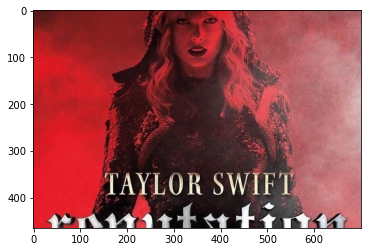

In [249]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

rep_PATH = '/blue/zoo4926/juliabruner/Taylor_img/tsRep_image.jpeg'
image = mpimg.imread(rep_PATH)
plt.imshow(image)

### LOVER ERA

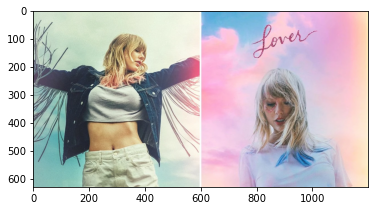

In [250]:
lover_PATH = '/blue/zoo4926/juliabruner/Taylor_img/tsLover_img.webp'
image = mpimg.imread(lover_PATH)
plt.imshow(image)


### FOLKLORE / EVERMORE ERA

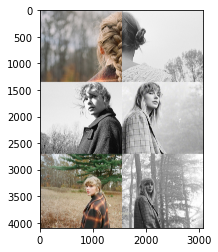

In [251]:
FE_PATH = '/blue/zoo4926/juliabruner/Taylor_img/tsFolkEver_img.jpeg'
image = mpimg.imread(FE_PATH)
plt.imshow(image)

# LSTM Model for Text Generation

In [252]:
# import the necessary packages
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text \
    import text_to_word_sequence
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

In [253]:
# DEFINE VARIABLES
EPOCHS = 50
BATCH_SIZE = 256
# INPUT_FILE_NAME = ____
WINDOW_LENGTH = 10
WINDOW_STEP = 1
PREDICT_LENGTH = 3
MAX_WORDS = 25000
EMBEDDING_WIDTH = 250

# TOKENIZATION

In [265]:
# SPLITTING CORPUSES FOR EACH ERA 
rep = reputation_corpus.split(' ') # This has it splitting by word now, not character, TOKENIZER NOT WORKING PROPERLY
remove1 = 'official'
remove2 = 'lyrics'
remove3 = 'joeboy'
remove4 = 'a'
remove5 = 'i'
remove6 = 'verified'
while remove1 in rep: rep.remove(remove1)  
while remove2 in rep: rep.remove(remove2)  
while remove3 in rep: rep.remove(remove3)  
while remove4 in rep: rep.remove(remove4)  
while remove5 in rep: rep.remove(remove5)  
while remove5 in rep: rep.remove(remove5) 
while remove6 in rep: rep.remove(remove6) 

fe_corpus = folklore_corpus + ' ' + evermore_corpus
fe = fe_corpus.split(' ')

In [266]:
# Reputation Training Data
rep_fragments = []
rep_targets = []
for i in range(0, len(rep) - WINDOW_LENGTH, WINDOW_STEP):
    rep_fragments.append(rep[i: i + WINDOW_LENGTH])
    rep_targets.append(rep[i + WINDOW_LENGTH])
    
# Lover Training Data
lover_fragments = []
lover_targets = []
for i in range(0, len(lover) - WINDOW_LENGTH, WINDOW_STEP):
    lover_fragments.append(lover[i: i + WINDOW_LENGTH])
    lover_targets.append(lover[i + WINDOW_LENGTH])
    
# Folklore/Evermore Training Data
fe_fragments = []
fe_targets = []
for i in range(0, len(fe) - WINDOW_LENGTH, WINDOW_STEP):
    fe_fragments.append(fe[i: i + WINDOW_LENGTH])
    fe_targets.append(fe[i + WINDOW_LENGTH])
    

In [267]:
# Checking that input sequence length matches number of targets

# Reputation
print(len(rep_fragments))
print(len(rep_targets))

# Lover
print(len(lover_fragments))
print(len(lover_targets))

# Folklore/Evermore
print(len(fe_fragments))
print(len(fe_targets))

7074
7074
7209
7209
11643
11643


## Tokens -> Indicies

In [268]:
# Convert to indices

# Reputation
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='UNK')
tokenizer.fit_on_texts(rep)
rep_fragments_indexed = tokenizer.texts_to_sequences(rep_fragments)
rep_targets_indexed = tokenizer.texts_to_sequences(rep_targets)

# Lover
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='UNK')
tokenizer.fit_on_texts(lover)
lover_fragments_indexed = tokenizer.texts_to_sequences(lover_fragments)
lover_targets_indexed = tokenizer.texts_to_sequences(lover_targets)

# Folklore/Evermore
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='UNK')
tokenizer.fit_on_texts(fe)
fe_fragments_indexed = tokenizer.texts_to_sequences(fe_fragments)
fe_targets_indexed = tokenizer.texts_to_sequences(fe_targets)


## Format for LSTM input/output (np.array)

In [269]:
# Convert to appropriate input and output formats

# Reputation
X_rep = np.array(rep_fragments_indexed, dtype=np.int64)
y_rep = np.zeros((len(rep_targets_indexed), MAX_WORDS))
for i, target_index in enumerate(rep_targets_indexed):
    y_rep[i, target_index] = 1
    
    
# Lover
X_lover = np.array(lover_fragments_indexed, dtype=np.int64)
y_lover = np.zeros((len(lover_targets_indexed), MAX_WORDS))
for i, target_index in enumerate(lover_targets_indexed):
    y_lover[i, target_index] = 1


# Folklore/Evermore
X_fe = np.array(fe_fragments_indexed, dtype=np.int64)
y_fe = np.zeros((len(fe_targets_indexed), MAX_WORDS))
for i, target_index in enumerate(fe_targets_indexed):
    y_fe[i, target_index] = 1

## Checking Tokenization & Input Sequences Format

In [270]:
# Used the number 13 randomly, 13 is TS's lucky number

# Reputation
print(f'Fragment: {rep_fragments[13]}\nTarget: {rep_targets[13]}')
print(f'\nTotal fragments: {len(rep_fragments)}')
    
    
# Lover
print(f'Fragment: {lover_fragments[13]}\nTarget: {lover_targets[13]}')
print(f'\nTotal fragments: {len(lover_fragments)}')
    

# Folklore/Evermore
print(f'Fragment: {fe_fragments[13]}\nTarget: {fe_targets[13]}')
print(f'\nTotal fragments: {len(fe_fragments)}')
    

Fragment: ['he', 'had', 'loved', 'and', 'left', 'haunted', 'but', 'if', 'he', 'is']
Target: ghost

Total fragments: 7074
Fragment: ['wrong', 'wrong', 'lived', 'in', 'the', 'shade', 'you', 'were', 'throwing', 'until']
Target: all

Total fragments: 7209
Fragment: ['instead', 'of', 'no', 'i', 'thought', 'i', 'saw', 'you', 'at', 'the']
Target: bus

Total fragments: 11643


## Creating Training Models

In [271]:
# Reputation LSTM

rep_training_model = Sequential()
rep_training_model.add(Embedding(
    output_dim=EMBEDDING_WIDTH, input_dim=MAX_WORDS,
    mask_zero=True, input_length=None))
rep_training_model.add(LSTM(128, return_sequences=True,
                        dropout=0.2, recurrent_dropout=0.2))
rep_training_model.add(LSTM(128, dropout=0.2,
                        recurrent_dropout=0.2))
rep_training_model.add(Dense(128, activation='relu'))
rep_training_model.add(Dense(MAX_WORDS, activation='softmax'))
rep_training_model.compile(loss='categorical_crossentropy',
                       optimizer='adam')
rep_training_model.summary()
rep_history = rep_training_model.fit(X_rep, y_rep, validation_split=0.05,
                             batch_size=BATCH_SIZE, 
                             epochs=EPOCHS, verbose=2, 
                             shuffle=True)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_34 (Embedding)    (None, None, 250)         6250000   
                                                                 
 lstm_68 (LSTM)              (None, None, 128)         194048    
                                                                 
 lstm_69 (LSTM)              (None, 128)               131584    
                                                                 
 dense_68 (Dense)            (None, 128)               16512     
                                                                 
 dense_69 (Dense)            (None, 25000)             3225000   
                                                                 
Total params: 9,817,144
Trainable params: 9,817,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
27/27 - 5s - loss: 8.6812 - val_

In [117]:
# Lover LSTM

lover_training_model = Sequential()
lover_training_model.add(Embedding(
    output_dim=EMBEDDING_WIDTH, input_dim=MAX_WORDS,
    mask_zero=True, input_length=None))
lover_training_model.add(LSTM(128, return_sequences=True,
                        dropout=0.2, recurrent_dropout=0.2))
lover_training_model.add(LSTM(128, dropout=0.2,
                        recurrent_dropout=0.2))
lover_training_model.add(Dense(128, activation='relu'))
lover_training_model.add(Dense(MAX_WORDS, activation='softmax'))
lover_training_model.compile(loss='categorical_crossentropy',
                       optimizer='adam')
lover_training_model.summary()
lover_history = lover_training_model.fit(X_lover, y_lover, validation_split=0.05,
                             batch_size=BATCH_SIZE, 
                             epochs=EPOCHS, verbose=2, 
                             shuffle=True)

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_19 (Embedding)    (None, None, 250)         6250000   
                                                                 
 lstm_38 (LSTM)              (None, None, 128)         194048    
                                                                 
 lstm_39 (LSTM)              (None, 128)               131584    
                                                                 
 dense_38 (Dense)            (None, 128)               16512     
                                                                 
 dense_39 (Dense)            (None, 25000)             3225000   
                                                                 
Total params: 9,817,144
Trainable params: 9,817,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
27/27 - 5s - loss: 8.7472 - val_

In [86]:
# Folklore / Evermore LSTM

fe_training_model = Sequential()
fe_training_model.add(Embedding(
    output_dim=EMBEDDING_WIDTH, input_dim=MAX_WORDS,
    mask_zero=True, input_length=None))
fe_training_model.add(LSTM(128, return_sequences=True,
                        dropout=0.2, recurrent_dropout=0.2))
fe_training_model.add(LSTM(128, dropout=0.2,
                        recurrent_dropout=0.2))
fe_training_model.add(Dense(128, activation='relu'))
fe_training_model.add(Dense(MAX_WORDS, activation='softmax'))
fe_training_model.compile(loss='categorical_crossentropy',
                       optimizer='adam')
fe_training_model.summary()
fe_history = fe_training_model.fit(X_fe, y_fe, validation_split=0.05,
                             batch_size=BATCH_SIZE, 
                             epochs=EPOCHS, verbose=2, 
                             shuffle=True)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_14 (Embedding)    (None, None, 250)         6250000   
                                                                 
 lstm_28 (LSTM)              (None, None, 128)         194048    
                                                                 
 lstm_29 (LSTM)              (None, 128)               131584    
                                                                 
 dense_28 (Dense)            (None, 128)               16512     
                                                                 
 dense_29 (Dense)            (None, 25000)             3225000   
                                                                 
Total params: 9,817,144
Trainable params: 9,817,144
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
44/44 - 7s - loss: 8.0517 - val_

## Creating Inference Models

In [272]:
# Reputation

rep_inference_model = Sequential()
rep_inference_model.add(Embedding(
    output_dim=EMBEDDING_WIDTH, input_dim=MAX_WORDS,
    mask_zero=True, batch_input_shape=(1, 1)))
rep_inference_model.add(LSTM(128, return_sequences=True,
                         dropout=0.2, recurrent_dropout=0.2,
                         stateful=True))
rep_inference_model.add(LSTM(128, dropout=0.2,
                         recurrent_dropout=0.2, stateful=True))
rep_inference_model.add(Dense(128, activation='relu'))
rep_inference_model.add(Dense(MAX_WORDS, activation='softmax'))
rep_weights = rep_training_model.get_weights()
rep_inference_model.set_weights(rep_weights)

In [119]:
# Lover

lover_inference_model = Sequential()
lover_inference_model.add(Embedding(
    output_dim=EMBEDDING_WIDTH, input_dim=MAX_WORDS,
    mask_zero=True, batch_input_shape=(1, 1)))
lover_inference_model.add(LSTM(128, return_sequences=True,
                         dropout=0.2, recurrent_dropout=0.2,
                         stateful=True))
lover_inference_model.add(LSTM(128, dropout=0.2,
                         recurrent_dropout=0.2, stateful=True))
lover_inference_model.add(Dense(128, activation='relu'))
lover_inference_model.add(Dense(MAX_WORDS, activation='softmax'))
lover_weights = lover_training_model.get_weights()
lover_inference_model.set_weights(lover_weights)

In [89]:
# Folklore / Evermore 

fe_inference_model = Sequential()
fe_inference_model.add(Embedding(
    output_dim=EMBEDDING_WIDTH, input_dim=MAX_WORDS,
    mask_zero=True, batch_input_shape=(1, 1)))
fe_inference_model.add(LSTM(128, return_sequences=True,
                         dropout=0.2, recurrent_dropout=0.2,
                         stateful=True))
fe_inference_model.add(LSTM(128, dropout=0.2,
                         recurrent_dropout=0.2, stateful=True))
fe_inference_model.add(Dense(128, activation='relu'))
fe_inference_model.add(Dense(MAX_WORDS, activation='softmax'))
fe_weights = fe_training_model.get_weights()
fe_inference_model.set_weights(fe_weights)

# Generating Lyric Predictions

# Predicting words in popular TS songs

### 1. can't you see that I'm the one who...

In [273]:
# Reputation Prediction
first_words = ['can', 'not', 'you', 'see', 'that', 'i', 'am', 'the', 'one', 'who']
first_words_indexed = tokenizer.texts_to_sequences(
    first_words)
rep_inference_model.reset_states()
predicted_string = ''

# Feed initial words to the model.
for i, word_index in enumerate(first_words_indexed):
    x = np.zeros((1, 1), dtype=np.int64)
    x[0][0] = word_index[0]
    predicted_string += first_words[i]
    predicted_string += ' '
    y_predict = rep_inference_model.predict(x, verbose=0)[0]

# Predict PREDICT_LENGTH words.
for i in range(PREDICT_LENGTH):
    new_word_index = np.argmax(y_predict)
    word = tokenizer.sequences_to_texts(
        [[new_word_index]])
    x[0][0] = new_word_index
    predicted_string += word[0]
    predicted_string += ' '
    y_predict = rep_inference_model.predict(x, verbose=0)[0]
print(predicted_string)

can not you see that i am the one who could long see 


In [121]:
# Lover Prediction
first_words = ['can', 'not', 'you', 'see', 'that', 'i', 'am', 'the', 'one', 'who']
first_words_indexed = tokenizer.texts_to_sequences(
    first_words)
lover_inference_model.reset_states()
predicted_string = ''

# Feed initial words to the model.
for i, word_index in enumerate(first_words_indexed):
    x = np.zeros((1, 1), dtype=np.int64)
    x[0][0] = word_index[0]
    predicted_string += first_words[i]
    predicted_string += ' '
    y_predict = lover_inference_model.predict(x, verbose=0)[0]

# Predict PREDICT_LENGTH words.
for i in range(PREDICT_LENGTH):
    new_word_index = np.argmax(y_predict)
    word = tokenizer.sequences_to_texts(
        [[new_word_index]])
    x[0][0] = new_word_index
    predicted_string += word[0]
    predicted_string += ' '
    y_predict = lover_inference_model.predict(x, verbose=0)[0]
print(predicted_string)

can not you see that i am the one who now i was 


In [115]:
# Folklore / Evermore Prediction
first_words = ['can', 'not', 'you', 'see', 'that', 'i', 'am', 'the', 'one', 'who']
first_words_indexed = tokenizer.texts_to_sequences(
    first_words)
fe_inference_model.reset_states()
predicted_string = ''

# Feed initial words to the model.
for i, word_index in enumerate(first_words_indexed):
    x = np.zeros((1, 1), dtype=np.int64)
    x[0][0] = word_index[0]
    predicted_string += first_words[i]
    predicted_string += ' '
    y_predict = fe_inference_model.predict(x, verbose=0)[0]

# Predict PREDICT_LENGTH words.
for i in range(PREDICT_LENGTH):
    new_word_index = np.argmax(y_predict)
    word = tokenizer.sequences_to_texts(
        [[new_word_index]])
    x[0][0] = new_word_index
    predicted_string += word[0]
    predicted_string += ' '
    y_predict = fe_inference_model.predict(x, verbose=0)[0]
print(predicted_string)

can not you see that i am the one who was a warning 


### 2. He knelt to the ground and pulled out a...

In [213]:
# Reputation Prediction
first_words = ['he', 'knelt', 'to', 'the', 'ground', 'and', 'pulled', 'out', 'a']
first_words_indexed = tokenizer.texts_to_sequences(
    first_words)
#rep_inference_model.reset_states()
predicted_string = ''

# Feed initial words to the model.
for i, word_index in enumerate(first_words_indexed):
    x = np.zeros((1, 1), dtype=np.int64)
    x[0][0] = word_index[0]
    predicted_string += first_words[i]
    predicted_string += ' '
    y_predict = rep_inference_model.predict(x, verbose=0)[0]

# Predict PREDICT_LENGTH words.
for i in range(PREDICT_LENGTH):
    new_word_index = np.argmax(y_predict)
    word = tokenizer.sequences_to_texts(
        [[new_word_index]])
    x[0][0] = new_word_index
    predicted_string += word[0]
    predicted_string += ' '
    y_predict = rep_inference_model.predict(x, verbose=0)[0]
print(predicted_string)

he knelt to the ground and pulled out a you a me 


In [124]:
# Lover Prediction
first_words = ['he', 'knelt', 'to', 'the', 'ground', 'and', 'pulled', 'out', 'a' ]
first_words_indexed = tokenizer.texts_to_sequences(
    first_words)
lover_inference_model.reset_states()
predicted_string = ''

# Feed initial words to the model.
for i, word_index in enumerate(first_words_indexed):
    x = np.zeros((1, 1), dtype=np.int64)
    x[0][0] = word_index[0]
    predicted_string += first_words[i]
    predicted_string += ' '
    y_predict = lover_inference_model.predict(x, verbose=0)[0]

# Predict PREDICT_LENGTH words.
for i in range(PREDICT_LENGTH):
    new_word_index = np.argmax(y_predict)
    word = tokenizer.sequences_to_texts(
        [[new_word_index]])
    x[0][0] = new_word_index
    predicted_string += word[0]
    predicted_string += ' '
    y_predict = lover_inference_model.predict(x, verbose=0)[0]
print(predicted_string)

he knelt to the ground and pulled out a for the we 


In [123]:
# Folklore / Evermore Prediction
first_words = ['he', 'knelt', 'to', 'the', 'ground', 'and', 'pulled', 'out', 'a' ]
first_words_indexed = tokenizer.texts_to_sequences(
    first_words)
fe_inference_model.reset_states()
predicted_string = ''

# Feed initial words to the model.
for i, word_index in enumerate(first_words_indexed):
    x = np.zeros((1, 1), dtype=np.int64)
    x[0][0] = word_index[0]
    predicted_string += first_words[i]
    predicted_string += ' '
    y_predict = fe_inference_model.predict(x, verbose=0)[0]

# Predict PREDICT_LENGTH words.
for i in range(PREDICT_LENGTH):
    new_word_index = np.argmax(y_predict)
    word = tokenizer.sequences_to_texts(
        [[new_word_index]])
    x[0][0] = new_word_index
    predicted_string += word[0]
    predicted_string += ' '
    y_predict = fe_inference_model.predict(x, verbose=0)[0]
print(predicted_string)

he knelt to the ground and pulled out a hope of you 


### 3. Hey, I don't know about you, but I'm feeling...

'i', 'do', 'not', 'know', 'about', 'you', 'but', 'i', 'am', 'feeling'

In [214]:
# Reputation Prediction
first_words = ['i', 'do', 'not', 'know', 'about', 'you', 'but', 'i', 'am', 'feeling']
first_words_indexed = tokenizer.texts_to_sequences(
    first_words)
rep_inference_model.reset_states()
predicted_string = ''

# Feed initial words to the model.
for i, word_index in enumerate(first_words_indexed):
    x = np.zeros((1, 1), dtype=np.int64)
    x[0][0] = word_index[0]
    predicted_string += first_words[i]
    predicted_string += ' '
    y_predict = rep_inference_model.predict(x, verbose=0)[0]

# Predict PREDICT_LENGTH words.
for i in range(PREDICT_LENGTH):
    new_word_index = np.argmax(y_predict)
    word = tokenizer.sequences_to_texts(
        [[new_word_index]])
    x[0][0] = new_word_index
    predicted_string += word[0]
    predicted_string += ' '
    y_predict = rep_inference_model.predict(x, verbose=0)[0]
print(predicted_string)

i do not know about you but i am feeling back i on 


In [139]:
# Lover Prediction
first_words = ['i', 'do', 'not', 'know', 'about', 'you', 'but', 'i', 'am', 'feeling']
first_words_indexed = tokenizer.texts_to_sequences(
    first_words)
lover_inference_model.reset_states()
predicted_string = ''

# Feed initial words to the model.
for i, word_index in enumerate(first_words_indexed):
    x = np.zeros((1, 1), dtype=np.int64)
    x[0][0] = word_index[0]
    predicted_string += first_words[i]
    predicted_string += ' '
    y_predict = lover_inference_model.predict(x, verbose=0)[0]

# Predict PREDICT_LENGTH words.
for i in range(PREDICT_LENGTH):
    new_word_index = np.argmax(y_predict)
    word = tokenizer.sequences_to_texts(
        [[new_word_index]])
    x[0][0] = new_word_index
    predicted_string += word[0]
    predicted_string += ' '
    y_predict = lover_inference_model.predict(x, verbose=0)[0]
print(predicted_string)

i do not know about you but i am feeling the we i 


In [140]:
# Folklore / Evermore Prediction
first_words = ['i', 'do', 'not', 'know', 'about', 'you', 'but', 'i', 'am', 'feeling']
first_words_indexed = tokenizer.texts_to_sequences(
    first_words)
fe_inference_model.reset_states()
predicted_string = ''

# Feed initial words to the model.
for i, word_index in enumerate(first_words_indexed):
    x = np.zeros((1, 1), dtype=np.int64)
    x[0][0] = word_index[0]
    predicted_string += first_words[i]
    predicted_string += ' '
    y_predict = fe_inference_model.predict(x, verbose=0)[0]

# Predict PREDICT_LENGTH words.
for i in range(PREDICT_LENGTH):
    new_word_index = np.argmax(y_predict)
    word = tokenizer.sequences_to_texts(
        [[new_word_index]])
    x[0][0] = new_word_index
    predicted_string += word[0]
    predicted_string += ' '
    y_predict = fe_inference_model.predict(x, verbose=0)[0]
print(predicted_string)

i do not know about you but i am feeling a marvelous time 


# Embedding

In [192]:
# Reputation

embeddings = rep_training_model.layers[0].get_weights()[0]
lookup_words = ['she', 'he', 'they', 'said', 'good',
                'bad']
for lookup_word in lookup_words:
    lookup_word_indexed = tokenizer.texts_to_sequences(
        [lookup_word])
    print('words close to:', lookup_word)
    lookup_embedding = embeddings[lookup_word_indexed[0]]
    word_indices = {}
    # Calculate distances.
    for i, embedding in enumerate(embeddings):
        distance = np.linalg.norm(
            embedding - lookup_embedding)
        word_indices[distance] = i
    # Print sorted by distance.
    for distance in sorted(word_indices.keys())[:5]:
        word_index = word_indices[distance]
        word = tokenizer.sequences_to_texts([[word_index]])[0]
        print(word + ': ', distance)
    print('')

words close to: she
she:  0.0
was:  0.855893
life:  0.87616634
where:  0.890507
picture:  0.8985473

words close to: he
he:  0.0
are:  0.91057205
what:  0.92194414
catching:  0.96362746
hey:  1.0016079

words close to: they
they:  0.0
crestfallen:  0.9222686
soon:  0.9664934
shame:  0.99119633
parents:  0.99196523

words close to: said
said:  0.0
motion:  0.958645
that:  0.9704508
of:  0.97182894
would:  0.97246593

words close to: good
good:  0.0
tires:  1.1217633
other:  1.1723746
line:  1.1769317
hair:  1.1852186

words close to: bad
bad:  0.0
left:  1.1144958
woman:  1.1511248
wanting:  1.2315485
survived:  1.2321348



In [193]:
# Lover

embeddings = lover_training_model.layers[0].get_weights()[0]
lookup_words = ['she', 'he', 'they', 'said', 'good',
                'bad']
for lookup_word in lookup_words:
    lookup_word_indexed = tokenizer.texts_to_sequences(
        [lookup_word])
    print('words close to:', lookup_word)
    lookup_embedding = embeddings[lookup_word_indexed[0]]
    word_indices = {}
    # Calculate distances.
    for i, embedding in enumerate(embeddings):
        distance = np.linalg.norm(
            embedding - lookup_embedding)
        word_indices[distance] = i
    # Print sorted by distance.
    for distance in sorted(word_indices.keys())[:5]:
        word_index = word_indices[distance]
        word = tokenizer.sequences_to_texts([[word_index]])[0]
        print(word + ': ', distance)
    print('')

words close to: she
she:  0.0
would:  0.9700348
missing:  0.9780509
love:  0.98915833
sun:  1.0052686

words close to: he
he:  0.0
open:  0.84462404
place:  0.84885
it:  0.9087664
remember:  0.91029346

words close to: they
they:  0.0
UNK:  0.6651247
UNK:  0.66662353
UNK:  0.6704282
UNK:  0.6707746

words close to: said
said:  0.0
ricochet:  1.0251827
haunt:  1.0650922
today:  1.0739172
count:  1.0968285

words close to: good
good:  0.0
UNK:  0.8601058
magazines:  0.86425924
dancing:  0.8668437
live:  0.86806494

words close to: bad
bad:  0.0
shattered:  0.8851263
flying:  0.8986705
well:  0.915391
gave:  0.91678286



In [194]:
# Folklore/Evermore

embeddings = fe_training_model.layers[0].get_weights()[0]
lookup_words = ['she', 'he', 'they', 'said', 'good',
                'bad']
for lookup_word in lookup_words:
    lookup_word_indexed = tokenizer.texts_to_sequences(
        [lookup_word])
    print('words close to:', lookup_word)
    lookup_embedding = embeddings[lookup_word_indexed[0]]
    word_indices = {}
    # Calculate distances.
    for i, embedding in enumerate(embeddings):
        distance = np.linalg.norm(
            embedding - lookup_embedding)
        word_indices[distance] = i
    # Print sorted by distance.
    for distance in sorted(word_indices.keys())[:5]:
        word_index = word_indices[distance]
        word = tokenizer.sequences_to_texts([[word_index]])[0]
        print(word + ': ', distance)
    print('')

words close to: she
she:  0.0
would:  0.9133205
season:  0.9351908
not:  0.96432465
you:  0.96438104

words close to: he
he:  0.0
we:  1.025416
telling:  1.1822981
lookout:  1.2533143
dorm:  1.2572281

words close to: they
they:  0.0
UNK:  0.8228349
UNK:  0.8456412
UNK:  0.84730625
UNK:  0.8483782

words close to: said
said:  0.0
want:  0.9477357
brother:  0.95421135
times:  1.0027077
that:  1.0097163

words close to: good
good:  0.0
UNK:  0.9334529
frozen:  0.93551725
UNK:  0.935686
UNK:  0.9366965

words close to: bad
bad:  0.0
last:  1.0239104
homeland:  1.0587261
problem:  1.063437
sipped:  1.0919087

